In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve

from tqdm.notebook import tqdm

np.random.seed(42)

# Helper function

In [10]:
def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    #r_train = recall_score(y_train, y_hat_train)
    #r_test = recall_score(y_test, y_hat_test)

    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

scores = pd.DataFrame(columns = ['f1_train', 'f1_test', 'accuracy_train', 
                                    'accuracy_test', 'roc_auc', 'pr_auc', 
                                    'model', 'vectorizer'])

def scoreTable(model, model_name, vectorizer, y_train, y_hat_train, y_test, y_hat_test):
    
    
    # storing scores
    f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc = return_scores(y_train, y_hat_train, y_test, y_hat_test)
    
    # list of scores
    score_list = []
    score_list.extend((f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc, 
                       repr(model), str(vectorizer)))
    
    # adding scores to score table
    scores.loc[model_name] = score_list
    return scores

def model_eval(model, model_name, vectorizer, X_train, X_test, y_train, y_test, column):
    
    X_train_vectorized = vectorizer.fit_transform(X_train[column])
    model.fit(X_train_vectorized, y_train)
    
    X_test_vectorized = vectorizer.transform(X_test[column])
    
    y_hat_train = model.predict(X_train_vectorized)
    y_hat_test = model.predict(X_test_vectorized)
    
    col_names = vectorizer.get_feature_names_out()
    
    return scoreTable(model, model_name, vectorizer, y_train, y_hat_train, 
                      y_test, y_hat_test) 

def model_eval_store(model, model_name, vectorizer, X_train, X_test, y_train, y_test, column):
    
    X_train_vectorized = vectorizer.fit_transform(X_train[column])
    model.fit(X_train_vectorized, y_train)
    
    X_test_vectorized = vectorizer.transform(X_test[column])
    
    y_hat_train = model.predict(X_train_vectorized)
    y_hat_test = model.predict(X_test_vectorized)
    
    col_names = vectorizer.get_feature_names_out()
    
    return X_train_vectorized, X_test_vectorized, y_hat_train, y_hat_test, col_names, \
    scoreTable(model, model_name, vectorizer, y_train, y_hat_train, y_test, y_hat_test) 

# Loading data

In [11]:
data = pd.read_csv("preprocessed_tweets2.csv")
test_data = pd.read_csv(f"preprocessed_tweets.csv")

C:\Users\User\AppData\Local\Temp\ipykernel_19160\3750343869.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("preprocessed_tweets2.csv")
C:\Users\User\AppData\Local\Temp\ipykernel_19160\3750343869.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(f"preprocessed_tweets.csv")


# Splitting the data

We will use a Train-Validation-Test Split of 6:2:2 (should be safe considering we have a large dataset of 1M data)

Validation Set (20%) to evaluate the performance during the development phase, helps in tuning hyperparameters  
Test Set (20%) to assess the final performance of the model

In [12]:
X = data.drop(columns='labels')
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.25) # 0.25 * 0.8 = 0.2

Checking the proportion of each class to make sure the data is balanced

In [13]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

labels
0    0.527867
1    0.472133
Name: proportion, dtype: float64
labels
0    0.5281
1    0.4719
Name: proportion, dtype: float64
labels
0    0.5235
1    0.4765
Name: proportion, dtype: float64


# Models

### Selecting a baseline model

We are using Logistic Regression as our baseline model with TF-IDF Vectorizer

In [16]:
MAX_FEAT = 450
MAX_ITER = 10000

baseline_model = LogisticRegression(max_iter=MAX_ITER)

vectorizer = TfidfVectorizer(max_features=MAX_FEAT)

vectorized_xtrain = vectorizer.fit_transform(X_train['text_without_stopwords'])
vectorized_xval = vectorizer.transform(X_val['text_without_stopwords'])

pd.DataFrame.sparse.from_spmatrix(vectorized_xtrain, columns=vectorizer.get_feature_names_out())

,account,ada,address,affiliatemarketing,ago,airdrop,airdropinspector,airdrops,alert,already,...,would,xlm,xom,xrp,year,years,yet,yieldfarming,ªð,ºð
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.320058,0.492741,0.368767,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
baseline_cv = cross_val_score(baseline_model, vectorized_xtrain, y_train)
baseline_cv

array([0.89091667, 0.89366667, 0.88425   , 0.88716667, 0.89125   ])

In [18]:
baseline_model.fit(vectorized_xtrain, y_train)

y_hat_train_baseline = baseline_model.predict(vectorized_xtrain)
y_hat_val_baseline = baseline_model.predict(vectorized_xval)

scoreTable(baseline_model, 'baseline', vectorizer, y_train, 
                   y_hat_train_baseline, y_val, y_hat_val_baseline)

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.875354,0.871624,0.890617,0.88615,0.882782,0.853979,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)


### Vectorizer Tuning

We will look at how changing the vectorizer affects the performance of the baseline model

In [19]:
models = [
        (LogisticRegression(), 'baseline_tfidf2', TfidfVectorizer(max_features=450), X_train, X_val, y_train, y_val, 'text_without_stopwords'), 
        (LogisticRegression(), 'baseline_tfidf3', TfidfVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_tfidf4', TfidfVectorizer(ngram_range=(2,2)), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_tfidf5', TfidfVectorizer(ngram_range=(2,2)), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_tfidf6', TfidfVectorizer(max_features=5000), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_cv', CountVectorizer(max_features=5000), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_cv2', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_cv3', CountVectorizer(ngram_range=(2,2)), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'baseline_cv4', CountVectorizer(ngram_range=(2,2)), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'tf_1000', TfidfVectorizer(max_features=1000), X_train, X_val, y_train, y_val, 'text_without_stopwords'), 
        (LogisticRegression(), 'tf_5000', TfidfVectorizer(max_features=5000), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'cv_1000', CountVectorizer(max_features=1000), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
        (LogisticRegression(), 'cv_5000', CountVectorizer(max_features=5000), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
]

In [20]:
for run in models:
    model_eval(*run)

display(scores)

d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.875354,0.871624,0.890617,0.88615,0.882782,0.853979,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_tfidf2,0.875354,0.871624,0.890617,0.88615,0.882782,0.853979,LogisticRegression(),TfidfVectorizer(max_features=450)
baseline_tfidf3,0.952913,0.929434,0.956600,0.93510,0.933388,0.914081,LogisticRegression(),TfidfVectorizer()
baseline_tfidf4,0.942388,0.759112,0.947867,0.80040,0.794098,0.751539,LogisticRegression(),"TfidfVectorizer(ngram_range=(2, 2))"
baseline_tfidf5,0.942388,0.759112,0.947867,0.80040,0.794098,0.751539,LogisticRegression(),"TfidfVectorizer(ngram_range=(2, 2))"
baseline_tfidf6,0.950475,0.933976,0.954267,0.93900,0.937494,0.918227,LogisticRegression(),TfidfVectorizer(max_features=5000)
baseline_cv,0.976739,0.960645,0.978167,0.96290,0.962333,0.946649,LogisticRegression(),CountVectorizer(max_features=5000)
baseline_cv2,0.988392,0.961235,0.989067,0.96345,0.962891,0.947429,LogisticRegression(),CountVectorizer()
baseline_cv3,0.995448,0.776276,0.995717,0.81705,0.810274,0.778653,LogisticRegression(),"CountVectorizer(ngram_range=(2, 2))"
baseline_cv4,0.995448,0.776276,0.995717,0.81705,0.810274,0.778653,LogisticRegression(),"CountVectorizer(ngram_range=(2, 2))"


Baseline_cv2 works best so we are going to use the vectorizer at Baseline_cv2

In [21]:
baseline_scores = scores

### Model Tuning

Resetting the score table and leaving the baseline and the most optimal one only

In [22]:
scores = scores.loc[['baseline', 'baseline_cv2']]
scores

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.875354,0.871624,0.890617,0.88615,0.882782,0.853979,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_cv2,0.988392,0.961235,0.989067,0.96345,0.962891,0.947429,LogisticRegression(),CountVectorizer()


**Before Regularization Code**

In [161]:
# models = [
#     (MultinomialNB(), 'mnb_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
#     (LinearSVC(), 'svc_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
#     (RandomForestClassifier(), 'rfc_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
#     (XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3), 'xgb_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
#     (GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3), 'gbm_cv', CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords'),
# ]

**After Regularization Code**

In [23]:
models = [
    # MultinomialNB with L2-like regularization
    (MultinomialNB(alpha=1.0), 'mnb_cv_l2', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
    
    # LinearSVC with L2 regularization
    (LinearSVC(penalty='l2', C=1.0), 'svc_cv_l2', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
    
    # LinearSVC with L1 regularization
    (LinearSVC(penalty='l1', dual=False, C=1.0), 'svc_cv_l1', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
    
    # RandomForest with adjusted hyperparameters to control complexity
    (RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2), 'rfc_cv', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),

    # XGBClassifier with L2 regularization
    (XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1.0), 'xgb_cv_l2', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),

    # XGBClassifier with L1 regularization
    (XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, reg_alpha=1.0), 'xgb_cv_l1', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),

    # XGBClassifier with Elastic Net-like regularization
    (XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1.0, reg_alpha=1.0), 'xgb_cv_elasticnet', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),

    # GradientBoosting with complexity control
    (GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=5, min_samples_leaf=2, subsample=0.8), 'gbm_cv', CountVectorizer(), X_train, X_val, y_train, y_val, 'text_without_stopwords'),
]

***Explanation about the regularization:***
1. **MultinomialNB**: Using `alpha` parameter for L2-like regularization.
2. **LinearSVC**: Separate models for L1 and L2 regularization.
3. **RandomForestClassifier**: Adjusting hyperparameters to control model complexity.
4. **XGBClassifier**: Separate models for L1, L2, and Elastic Net-like regularization.
5. **GradientBoostingClassifier**: Adjusting hyperparameters to control model complexity.

****

In [24]:
for run in models:
    model_eval(*run)

display(scores)

d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.875354,0.871624,0.890617,0.88615,0.882782,0.853979,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_cv2,0.988392,0.961235,0.989067,0.96345,0.962891,0.947429,LogisticRegression(),CountVectorizer()
mnb_cv_l2,0.906729,0.859250,0.911933,0.86545,0.865291,0.804118,MultinomialNB(),CountVectorizer()
svc_cv_l2,0.999471,0.972051,0.999500,0.97345,0.973248,0.959693,LinearSVC(),CountVectorizer()
svc_cv_l1,0.999100,0.981352,0.999150,0.98225,0.982157,0.972503,"LinearSVC(dual=False, penalty='l1')",CountVectorizer()
rfc_cv,0.528124,0.530961,0.694633,0.69285,0.678126,0.658292,"RandomForestClassifier(max_depth=10, min_sampl...",CountVectorizer()
xgb_cv_l2,0.816120,0.804718,0.849433,0.83940,0.832893,0.809924,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
xgb_cv_l1,0.815267,0.803696,0.848667,0.83855,0.832043,0.808623,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
xgb_cv_elasticnet,0.815267,0.803696,0.848667,0.83855,0.832043,0.808623,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
gbm_cv,0.827810,0.815492,0.857300,0.84660,0.840533,0.817064,"GradientBoostingClassifier(min_samples_leaf=2,...",CountVectorizer()


TOP 2 Models
1. svc_cv_l2
2. svc_cv_l1

We are going to hyper tune these 2 models

In [27]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for C
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

vec = CountVectorizer()
vec_xtrain_temp = vec.fit_transform(X_train['text_without_stopwords'])
vec_xval_temp = vec.transform(X_val['text_without_stopwords'])

svc_l1 = LinearSVC(penalty='l1', dual=False)
svc_l2 = LinearSVC(penalty='l2')

# Perform GridSearchCV for L1 
grid_search_l1 = GridSearchCV(svc_l1, param_grid, cv=5, scoring='accuracy')
grid_search_l1.fit(vec_xtrain_temp, y_train)

# Perform GridSearchCV for L2
grid_search_l2 = GridSearchCV(svc_l2, param_grid, cv=5, scoring='accuracy')
grid_search_l2.fit(vec_xtrain_temp, y_train)

# Print the best parameters and scores
print("Best C for L1 regularization:", grid_search_l1.best_params_)
print("Best score for L1 regularization:", grid_search_l1.best_score_)

print("Best C for L2 regularization:", grid_search_l2.best_params_)
print("Best score for L2 regularization:", grid_search_l2.best_score_)

# Evaluate the best models on the validation set
best_model_l1 = grid_search_l1.best_estimator_
best_model_l2 = grid_search_l2.best_estimator_

y_val_pred_l1 = best_model_l1.predict(vec_xval_temp)
y_val_pred_l2 = best_model_l2.predict(vec_xval_temp)

val_accuracy_l1 = accuracy_score(y_val, y_val_pred_l1)
val_accuracy_l2 = accuracy_score(y_val, y_val_pred_l2)

print("Validation Accuracy for L1 regularization:", val_accuracy_l1)
print("Validation Accuracy for L2 regularization:", val_accuracy_l2)

d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Python\environments\machine-lear

Best C for L1 regularization: {'C': 1}
Best score for L1 regularization: 0.9829333333333332
Best C for L2 regularization: {'C': 1}
Best score for L2 regularization: 0.9724499999999999
Validation Accuracy for L1 regularization: 0.9821
Validation Accuracy for L2 regularization: 0.97345


d:\Code\Python\environments\machine-learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


So, after checking the tuning, it is already the best tuning to set C = 1 both for 'svc_cv_l1' and 'svc_cv_l2'. From this, we can see that the 'svc_cv_l1' have the best performance and we will choose it as our final model

Adding the engineered feature is not possible since it is very RAM-Intensive so I will not add it

In [28]:
vec = CountVectorizer()
final_model = LinearSVC(penalty='l1', dual=False, C=1.0)

vec_xtrain = vec.fit_transform(X_train['text_without_stopwords'])
vec_xtest = vec.transform(X_test['text_without_stopwords'])

final_model.fit(vec_xtrain, y_train)

print(final_model.score(vec_xtrain, y_train))
print(final_model.score(vec_xtest, y_test))

y_hat_train_final = final_model.predict(vec_xtrain)
y_hat_test_final = final_model.predict(vec_xtest)

scoreTable(final_model, 'final_feat', vec, y_train, y_hat_train_final, y_test, y_hat_test_final)
display(scores)

0.99915
0.9834


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.875354,0.871624,0.890617,0.88615,0.882782,0.853979,LogisticRegression(max_iter=10000),TfidfVectorizer(max_features=450)
baseline_cv2,0.988392,0.961235,0.989067,0.96345,0.962891,0.947429,LogisticRegression(),CountVectorizer()
mnb_cv_l2,0.906729,0.859250,0.911933,0.86545,0.865291,0.804118,MultinomialNB(),CountVectorizer()
svc_cv_l2,0.999471,0.972051,0.999500,0.97345,0.973248,0.959693,LinearSVC(),CountVectorizer()
svc_cv_l1,0.999100,0.981352,0.999150,0.98225,0.982157,0.972503,"LinearSVC(dual=False, penalty='l1')",CountVectorizer()
rfc_cv,0.528124,0.530961,0.694633,0.69285,0.678126,0.658292,"RandomForestClassifier(max_depth=10, min_sampl...",CountVectorizer()
xgb_cv_l2,0.816120,0.804718,0.849433,0.83940,0.832893,0.809924,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
xgb_cv_l1,0.815267,0.803696,0.848667,0.83855,0.832043,0.808623,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
xgb_cv_elasticnet,0.815267,0.803696,0.848667,0.83855,0.832043,0.808623,"XGBClassifier(base_score=None, booster=None, c...",CountVectorizer()
gbm_cv,0.827810,0.815492,0.857300,0.84660,0.840533,0.817064,"GradientBoostingClassifier(min_samples_leaf=2,...",CountVectorizer()


In [29]:
X_train_vec, X_test_vec, y_hat_train, y_hat_test, col_names, score_table  = \
model_eval_store(LinearSVC(penalty='l1', dual=False, C=1.0), 'svc_cv', 
                 CountVectorizer(), X_train, X_test, y_train, y_test, 'text_without_stopwords')

Words like "best," "great," and "win" emerge with notably positive coefficients, signifying their strong association with favorable outcomes. Conversely, words such as "insane," "boring," and "worst" exhibit high negative coefficients, indicative of their potent connection to negative sentiments. The absolute coefficients further underscore the overall influence of these words, offering valuable insights into their relative importance. Additionally, nuances are evident, with words like "better" and "interesting" displaying positive coefficients but with varying degrees of impact compared to more strongly associated terms.

In [30]:
len(final_model.coef_)

1

In [31]:
coef_df = pd.DataFrame(final_model.coef_, columns=col_names).transpose()

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

,coef,coef_abs
insane,-5.612283,5.612283
retarded,-5.563931,5.563931
best,5.533427,5.533427
fly,5.475337,5.475337
lol,5.342750,5.342750
great,5.281682,5.281682
badly,-5.239865,5.239865
worst,-5.199876,5.199876
awesome,5.138041,5.138041
evil,-5.070390,5.070390


In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # for label size
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".2f")

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=45)
    plt.yticks(np.arange(len(classes)) + 0.5, classes, rotation=0)
    plt.tight_layout()
    plt.show()

Normalized confusion matrix


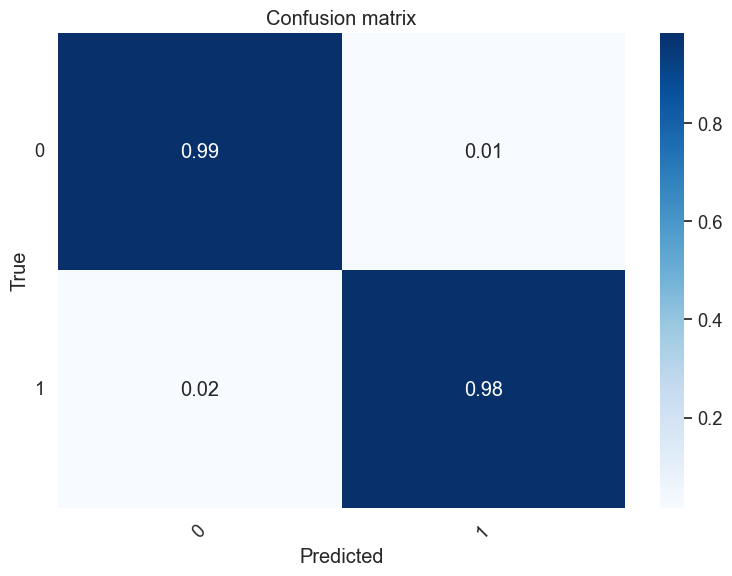

In [33]:
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=y_hat_test_final), classes=[0, 1], normalize=True)

#### Model comparison (F1-Score)

[]

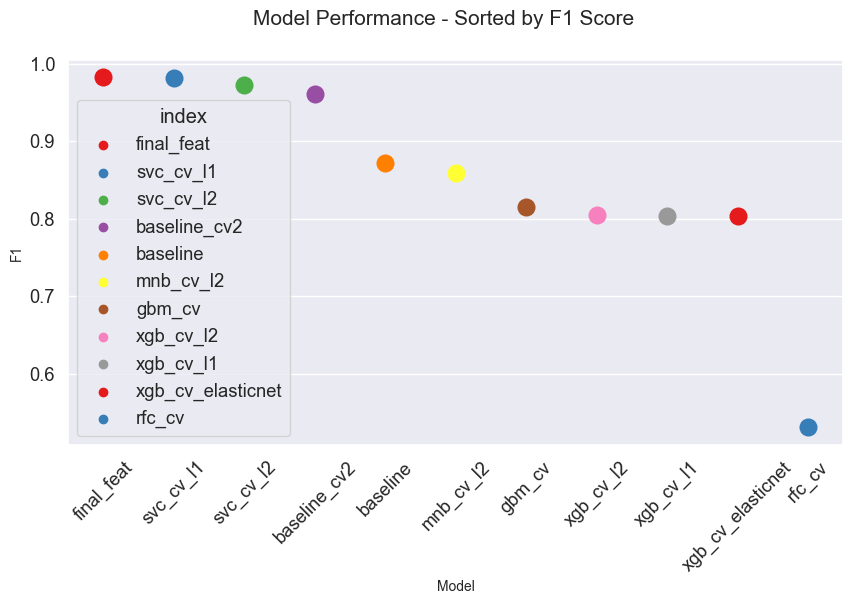

In [35]:
scores_viz_f1 = scores.sort_values(by=['f1_test'], ascending=False)[1:].reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="index", y="f1_test", data=scores_viz_f1, size=13, hue="index", palette="Set1")
plt.xticks(rotation = 45)
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("F1", fontsize=10)
fig.suptitle("Model Performance - Sorted by F1 Score", fontsize=15)
plt.plot()

#### Model comparison (Accuracy)

[]

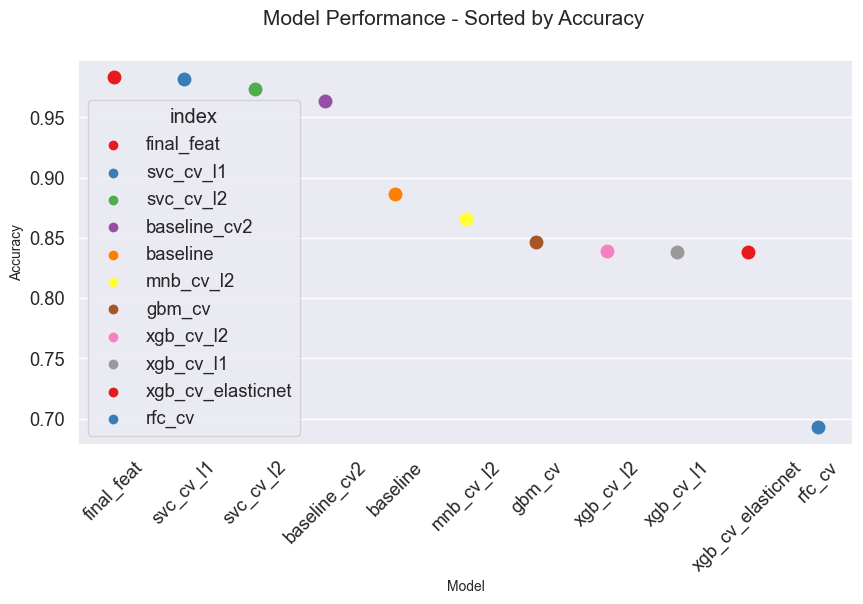

In [36]:
scores_viz_ac = scores.sort_values(by=['accuracy_test'], ascending=False)[1:].reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="index", y="accuracy_test", data=scores_viz_ac, size=10, hue="index", palette="Set1")
plt.xticks(rotation = 45)
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("Accuracy", fontsize=10)
fig.suptitle("Model Performance - Sorted by Accuracy", fontsize=15)
plt.plot()

In [37]:
from sklearn.calibration import CalibratedClassifierCV

vec_xtrain = vec.fit_transform(X_train['text_without_stopwords'])
vec_xtest = vec.transform(test_data['text_without_stopwords'])
y_test = test_data['labels']

# Calibrate the classifier to obtain probability estimates
calibrated_svc = CalibratedClassifierCV(final_model, method='sigmoid', cv='prefit')
calibrated_svc.fit(vec_xtrain, y_train)  

# Now predict probabilities instead of binary classes
probabilities = calibrated_svc.predict_proba(vec_xtest)

# Print the probabilities
print(probabilities)

[[0.85304857 0.14695143]
 [0.85803896 0.14196104]
 [0.84583928 0.15416072]
 ...
 [0.97516182 0.02483818]
 [0.08991286 0.91008714]
 [0.85561517 0.14438483]]


In [38]:
y_pred = calibrated_svc.predict(vec_xtest)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9727234544690894


In [39]:
import pickle

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vec, file)

# Save the trained model
with open('calibrated_svc_model.pkl', 'wb') as file:
    pickle.dump(calibrated_svc, file)